<a href="https://colab.research.google.com/github/Aminfaraji/predict_next_candlestick/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from glob import glob
import argparse
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# def windows_dataset(series,windows_size,batch_size):
#     # ds=tf.expand_dims(series.astype('float32'),axis=-1)
#     ds=tf.data.Dataset.from_tensor_slices(series.astype('float32'))
#     ds=ds.window(windows_size+1,shift=1,drop_remainder=True)
#     # ds=ds.flat_map(lambda w:w.batch(windows_size+1))
#     # ds=ds.map(lambda w:(w[:-1],w[-1]))
#     # ds=ds.batch(batch_size)
#     return ds

In [3]:
data=pd.read_csv('/content/drive/MyDrive/EURUSD15_1.csv',delimiter='\t',header=None,index_col=None)
data=pd.DataFrame(data.values,columns=["Data","Open","High","Low","Close","Volume"])
data.Data=pd.to_datetime(data.Data)
data=data.set_index("Data")
data=data.drop(['Volume'],axis=1)
# data

In [ ]:
# scale=MinMaxScaler()
# dataset_normalize=scale.fit_transform(data)

In [4]:
wind_open=[]
label_open=[]
wind_high=[]
label_high=[]
wind_low=[]
label_low=[]
wind_close=[]
label_close=[]
windows=32
data_=data.values
for i in range(len(data)-windows):

    wind_open.append(data_[:,0][i:i+windows])
    label_open.append(data_[:,0][i+windows])

    wind_high.append(data_[:,1][i:i+windows])
    label_high.append(data_[:,1][i+windows])

    wind_low.append(data_[:,2][i:i+windows])
    label_low.append(data_[:,2][i+windows])

    wind_close.append(data_[:,3][i:i+windows])
    label_close.append(data_[:,3][i+windows])

In [5]:
wind_open=np.reshape(wind_open,(len(wind_open),windows,1)).astype('float32')
wind_high=np.reshape(wind_high,(len(wind_high),windows,1)).astype('float32')
wind_low=np.reshape(wind_low,(len(wind_low),windows,1)).astype('float32')
wind_close=np.reshape(wind_close,(len(wind_close),windows,1)).astype('float32')
label_open=np.array(label_open).astype('float32')
label_high=np.array(label_high).astype('float32')
label_low=np.array(label_low).astype('float32')
label_close=np.array(label_close).astype('float32')

In [6]:
split_train=int(len(wind_open)*.8)

train_wind_open=wind_open[:split_train]
train_wind_high=wind_high[:split_train]
train_wind_low=wind_low[:split_train]
train_wind_close=wind_close[:split_train]
train_wind_open_label=label_open[:split_train]
train_wind_high_label=label_high[:split_train]
train_wind_low_label=label_low[:split_train]
train_wind_close_label=label_close[:split_train]

#-----------------------------------------------------------

test_wind_open=wind_open[split_train:]
test_wind_high=wind_high[split_train:]
test_wind_low=wind_low[split_train:]
test_wind_close=wind_close[split_train:]
test_wind_open_label=label_open[split_train:]
test_wind_high_label=label_high[split_train:]
test_wind_low_label=label_low[split_train:]
test_wind_close_label=label_close[split_train:]


In [7]:
input_size=[windows,1]
inp_A=tf.keras.Input(input_size,name='Open')
conv_A=tf.keras.layers.Conv1D(64,3,activation='relu',padding='causal')(inp_A)
lstm_A1=tf.keras.layers.LSTM(64,return_sequences=True)(conv_A)
lstm_A2=tf.keras.layers.LSTM(10)(lstm_A1)
outA=tf.keras.layers.Dense(1)(lstm_A2)
model_A=tf.keras.Model(inputs=inp_A,outputs=outA)

inp_B=tf.keras.Input(input_size,name='High')
conv_B=tf.keras.layers.Conv1D(64,3,activation='relu',padding='causal')(inp_B)
lstm_B1=tf.keras.layers.LSTM(64,return_sequences=True)(conv_B)
lstm_B2=tf.keras.layers.LSTM(10)(lstm_B1)
outB=tf.keras.layers.Dense(1)(lstm_B2)
model_B=tf.keras.Model(inputs=inp_B,outputs=outB)

inp_C=tf.keras.Input(input_size,name='Low')
conv_C=tf.keras.layers.Conv1D(64,3,activation='relu',padding='causal')(inp_C)
lstm_C1=tf.keras.layers.LSTM(64,return_sequences=True)(conv_C)
lstm_C2=tf.keras.layers.LSTM(10)(lstm_C1)
outC=tf.keras.layers.Dense(1)(lstm_C2)
model_C=tf.keras.Model(inputs=inp_C,outputs=outC)


inp_D=tf.keras.Input(input_size,name='Close')
conv_D=tf.keras.layers.Conv1D(64,3,activation='relu',padding='causal')(inp_D)
lstm_D1=tf.keras.layers.LSTM(64,return_sequences=True)(conv_D)
lstm_D2=tf.keras.layers.LSTM(10)(lstm_D1)
outD=tf.keras.layers.Dense(1)(lstm_D2)
model_D=tf.keras.Model(inputs=inp_D,outputs=outD)

con=tf.concat([model_A.output,model_B.output,model_C.output,model_D.output],axis=-1)

model_T=tf.keras.Model(inputs=[model_A.input,model_B.input,model_C.input,model_D.input],outputs=con)


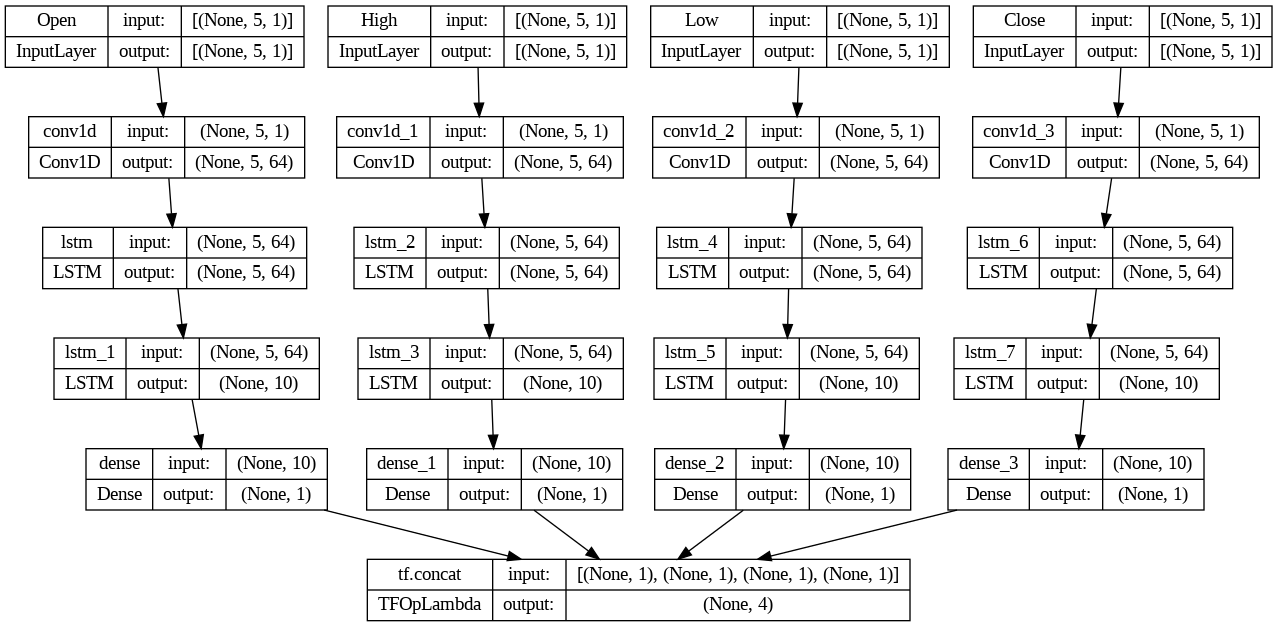

In [39]:
tf.keras.utils.plot_model(model_T,show_shapes=True)

In [48]:
checkpoint_path = "/content/drive/MyDrive/predict_candlestick/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


batch_size=32
# Calculate the number of batches per epoch
import math
n_batches = len(train_wind_open) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=20*n_batches)

# Create a new model instance
# model = create_model()
model_T.compile(tf.keras.optimizers.Adam(3e-4),tf.keras.losses.Huber(),metrics=['mse','mae','mape'])
# Save the weights using the `checkpoint_path` format
model_T.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_T.fit([train_wind_open,train_wind_high,train_wind_low,train_wind_close],
            [train_wind_open_label,train_wind_high_label,train_wind_low_label,train_wind_close_label],
            epochs=300,callbacks=[cp_callback])

In [8]:
# model_T.compile('adam',tf.keras.losses.Huber(),metrics=['mse','mae','mape'])


'/content/drive/MyDrive/predict_candlestick/cp-0280.ckpt'

In [9]:
model_T.load_weights(last)

In [8]:
# model_T.fit([train_wind_open,train_wind_high,train_wind_low,train_wind_close],
#             [train_wind_open_label,train_wind_high_label,train_wind_low_label,train_wind_close_label],epochs=1,batch_size=32)

In [36]:
pred=model_T.predict([test_wind_open[85:86],test_wind_high[85:86],test_wind_low[85:86],test_wind_close[85:86]])

1/1 [==============================] - 0s 37ms/step


In [49]:
#evaluate model with windows 5 and batch_size 32 is
#  loss=3.642699368811009e-07 and mae=0.0006535897264257073
#, mape= 0.060359224677085876 , mse= 7.285398737622018e-07,

model_T.evaluate([test_wind_open,test_wind_high,test_wind_low,test_wind_close],
 [test_wind_open_label,test_wind_high_label,test_wind_low_label,test_wind_close_label])

625/625 [==============================] - 14s 10ms/step - loss: 3.6427e-07 - mse: 7.2854e-07 - mae: 6.5359e-04 - mape: 0.0604


[3.642699368811009e-07,
 7.285398737622018e-07,
 0.0006535897264257073,
 0.060359224677085876]